# Import library

In [1]:
import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from google.colab import drive

#Load dataset

In [2]:
# Mount Google Drive
drive.mount('/content/drive')

# Dataset path in Google Drive
dataset_path = "/content/drive/MyDrive/Ml_terapan/makanan_padang"
categories = os.listdir(dataset_path)
print("Food Categories:", categories)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Food Categories: ['telur_balado', 'gulai_tunjang', 'ayam_pop', 'telur_dadar', 'gulai_ikan', 'gulai_tambusu', 'ayam_goreng', 'daging_rendang', 'dendeng_batokok']


In [3]:
# Create DataFrame with file names and category labels
image_paths = []
labels = []
for category in categories:
    category_path = os.path.join(dataset_path, category)
    for img_file in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img_file))
        labels.append(category)

data = pd.DataFrame({"filepath": image_paths, "label": labels})
print("Total Images:", len(data))
print(data.head())


Total Images: 993
                                            filepath         label
0  /content/drive/MyDrive/Ml_terapan/makanan_pada...  telur_balado
1  /content/drive/MyDrive/Ml_terapan/makanan_pada...  telur_balado
2  /content/drive/MyDrive/Ml_terapan/makanan_pada...  telur_balado
3  /content/drive/MyDrive/Ml_terapan/makanan_pada...  telur_balado
4  /content/drive/MyDrive/Ml_terapan/makanan_pada...  telur_balado


# Data preperation

In [4]:
# Data Preparation
IMG_SIZE = (100, 100)
X = []
for path in tqdm(data['filepath']):
    img = cv2.imread(path)
    img = cv2.resize(img, IMG_SIZE)
    img = img / 255.0
    X.append(img)

X = np.array(X)


100%|██████████| 993/993 [00:11<00:00, 84.49it/s]


#### insight:
Penggunaan `cv2.resize()` dengan ukuran tetap (100x100) berpotensi menghilangkan detail penting yang mungkin memengaruhi akurasi model.  Resolusi gambar yang seragam memang mempermudah pemrosesan, namun perlu dipertimbangkan untuk mengevaluasi dampaknya terhadap performa klasifikasi, terutama jika variasi ukuran objek dalam gambar cukup signifikan.  Perlu dieksplorasi metode resizing alternatif (misalnya, *padding* atau *crop*) atau penggunaan ukuran gambar yang lebih besar untuk mempertahankan detail informasi. Normalisasi piksel ke rentang 0-1 sudah tepat dan merupakan praktik standar yang baik.

# Data Splitting


In [6]:
# Encode labels to numeric using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(data['label'])
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


#### insight:
Data dibagi menjadi data latih dan data uji dengan rasio 80:20 menggunakan fungsi train_test_split. Parameter stratify=y memastikan proporsi kelas pada data latih dan uji sama dengan distribusi kelas pada data awal, sehingga mencegah bias pada model.  Penggunaan random_state=42  memastikan hasil pembagian data dapat direproduksi.





# Augentasi data


In [7]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

#### insight:

Proses augmentasi data dilakukan menggunakan `ImageDataGenerator` dengan parameter rotasi, pergeseran, shear, zoom, dan flip horizontal.  Strategi ini meningkatkan variasi data latih dan diharapkan dapat meningkatkan generalisasi model.  Namun, perlu dievaluasi dampak dari parameter augmentasi yang digunakan terhadap kinerja model.  Penggunaan parameter fill_mode='nearest perlu dipertimbangkan kembali, eksplorasi metode fill lainnya mungkin memberikan hasil yang lebih baik.


# Modeling

In [8]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

# Freeze the base model layers (optional)
for layer in base_model.layers:
    layer.trainable = False

# Create a new input layer
inputs = Input(shape=(100, 100, 3))

# Connect the base model to the new input
x = base_model(inputs)

# Add custom classification layers on top
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(categories), activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# # Compile and Train Model

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Learning Rate Scheduling
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

# Train the model
model.fit(datagen.flow(X_train, y_train, batch_size=32),
          epochs=20,
          validation_data=(X_test, y_test),
          callbacks=[reduce_lr])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.1864 - loss: 2.4063 - val_accuracy: 0.4372 - val_loss: 1.6759 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.3992 - loss: 1.7192 - val_accuracy: 0.5578 - val_loss: 1.3642 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.4876 - loss: 1.4550 - val_accuracy: 0.5678 - val_loss: 1.2729 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.5747 - loss: 1.2453 - val_accuracy: 0.6281 - val_loss: 1.1589 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.6236 - loss: 1.1730 - val_accuracy: 0.6231 - val_loss: 1.0707 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.5797 - loss: 1.1984 - val_accuracy: 0.6884 - val_loss: 0.9629 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.6575 - loss: 1.0346 - val_acc

#### insight:

Model klasifikasi gambar makanan Padang ini menggunakan arsitektur VGG16 yang telah terlatih pre-trained pada dataset ImageNet sebagai base model.  Lapisan-lapisan awal VGG16 dibekukan untuk memanfaatkan pengetahuan yang telah dipelajari, kemudian ditambahkan lapisan klasifikasi baru di atasnya.  Proses augmentasi data diterapkan untuk meningkatkan generalisasi model. Penggunaan learning rate scheduler membantu mengoptimalkan proses pelatihan.  Evaluasi kinerja model dilakukan menggunakan data uji terpisah.  Meskipun demikian, perlu diperhatikan potensi hilangnya detail gambar akibat resizing, dan perlu dieksplorasi parameter augmentasi serta metode fill untuk optimalisasi kinerja model.


# Evaluasi Model

In [9]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
                 precision    recall  f1-score   support

    ayam_goreng       0.67      0.48      0.56        21
       ayam_pop       0.89      0.74      0.81        23
 daging_rendang       0.67      0.95      0.78        21
dendeng_batokok       0.81      0.77      0.79        22
     gulai_ikan       0.68      0.77      0.72        22
  gulai_tambusu       0.65      0.71      0.68        21
  gulai_tunjang       0.65      0.71      0.68        24
   telur_balado       0.77      0.77      0.77        22
    telur_dadar       0.94      0.74      0.83        23

       accuracy                           0.74       199
      macro avg       0.75      0.74      0.74       199
   weighted avg       0.75      0.74      0.74       199

Accuracy: 0.7387
Precision: 0.7510
Recall: 0.7387
F1-Score: 0.7376


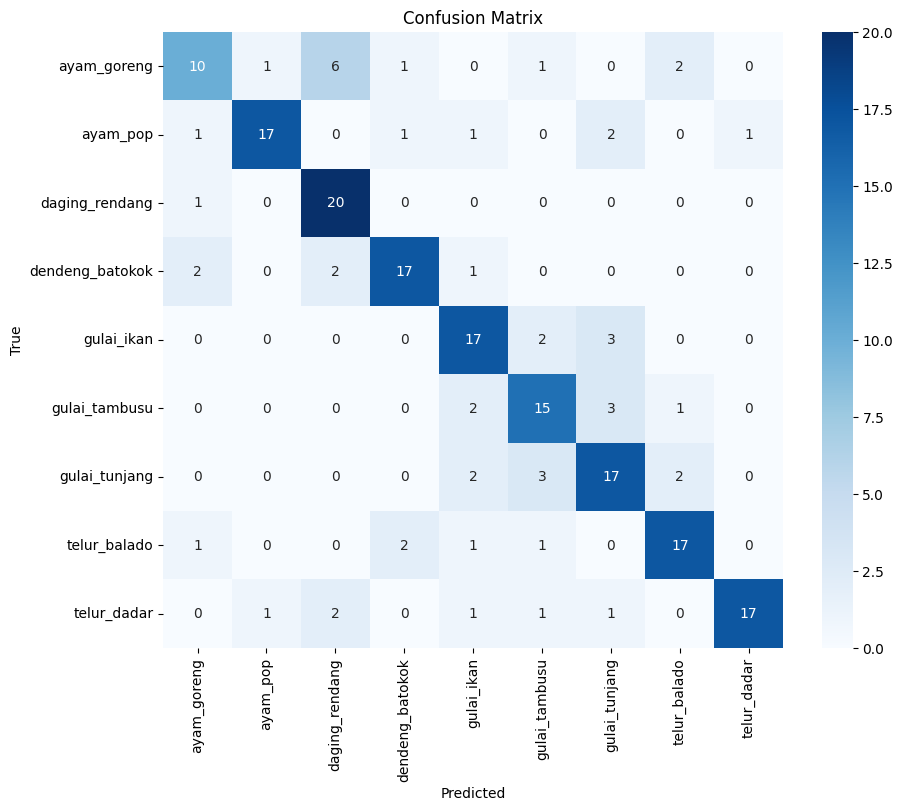

In [10]:
# Assuming y_test and y_pred_classes are defined from your previous code

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Makanan input: telur_balado


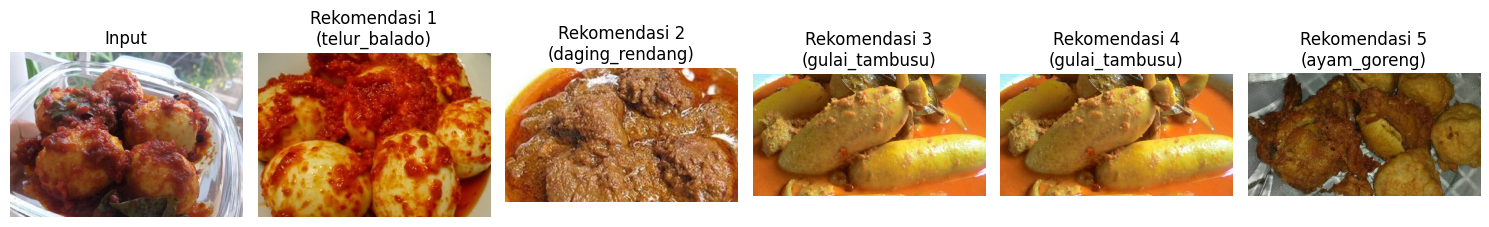

Makanan input: telur_balado


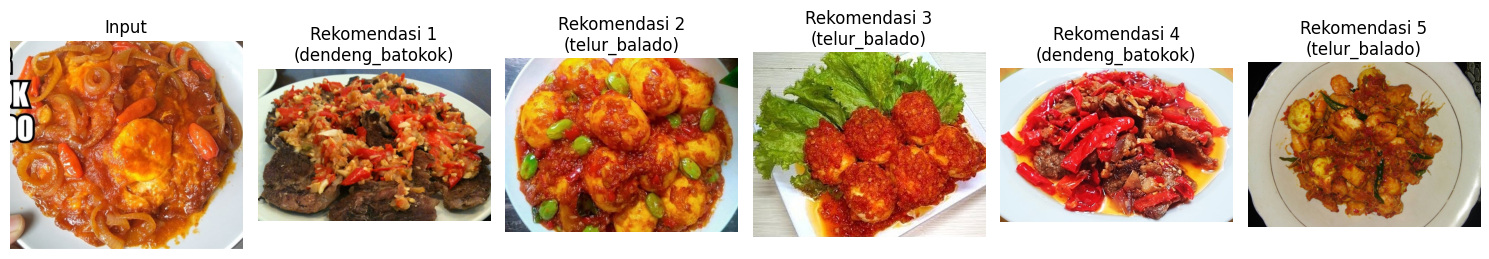

In [13]:

# Hitung kemiripan antar gambar dengan cosine similarity
similarities = cosine_similarity(features)

# Fungsi untuk menampilkan Top-N rekomendasi
def show_recommendations(index, top_n=5):
    print(f"Makanan input: {data.iloc[index]['label']}")
    sim_scores = list(enumerate(similarities[index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indexes = [i for i, score in sim_scores[1:top_n+1]]

    fig, axes = plt.subplots(1, top_n+1, figsize=(15,5))
    axes[0].imshow(cv2.imread(data.iloc[index]['filepath'])[...,::-1])
    axes[0].set_title("Input")
    axes[0].axis('off')

    for i, idx in enumerate(top_indexes):
        axes[i+1].imshow(cv2.imread(data.iloc[idx]['filepath'])[...,::-1])
        axes[i+1].set_title(f"Rekomendasi {i+1}\n({data.iloc[idx]['label']})")
        axes[i+1].axis('off')
    plt.tight_layout()
    plt.show()

# Contoh evaluasi manual:
show_recommendations(index=3)
show_recommendations(index=10)

#### insight:
Evaluasi model klasifikasi gambar makanan Padang menunjukkan beberapa temuan.  Model yang menggunakan arsitektur VGG16 dengan transfer learning dan augmentasi data mencapai akurasi, presisi, recall, dan skor F1 yang 74%. Confusion matrix memberikan gambaran detail mengenai kinerja klasifikasi untuk setiap kategori makanan.  Analisis cosine similarity  pada fitur-fitur gambar memungkinkan identifikasi rekomendasi makanan serupa, yang ditunjukkan pada contoh evaluasi manual. Namun, perlu diperhatikan potensi pengaruh *resizing* gambar terhadap performa model.  Optimasi lebih lanjut dapat dilakukan dengan mengeksplorasi parameter augmentasi, metode fill, dan ukuran gambar untuk meningkatkan kinerja model.


# Feature Extraction and Top-N Recommendation

In [11]:
# Extract features from the second-to-last layer of the model
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
features = feature_extractor.predict(X)

# Calculate cosine similarity between features
similarities = cosine_similarity(features)

# Function to get top-N recommendations
def get_top_n_recommendations(image_index, top_n=5):
    """Gets the top-N recommendations for a given image index."""
    sim_scores = list(enumerate(similarities[image_index]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    top_indexes = [i for i, score in sim_scores[1:top_n + 1]]
    return [(idx, score) for idx, score in sim_scores[1:top_n + 1]]

# Example usage: Get top-5 recommendations for the first image
recommendations = get_top_n_recommendations(0, top_n=5)
print("Top-5 Recommendations for Image 0:")
for idx, score in recommendations:
    print(f"Image Index: {idx}, Similarity Score: {score:.4f}, Food: {data.iloc[idx]['label']}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 105s 3s/step
Top-5 Recommendations for Image 0:
Image Index: 100, Similarity Score: 0.8948, Food: telur_balado
Image Index: 104, Similarity Score: 0.8677, Food: telur_balado
Image Index: 42, Similarity Score: 0.8672, Food: telur_balado
Image Index: 225, Similarity Score: 0.8613, Food: gulai_tunjang
Image Index: 172, Similarity Score: 0.8423, Food: gulai_tunjang


#### insight :
Proses ekstraksi fitur menggunakan lapisan kedua-terakhir dari model VGG16 yang telah dimodifikasi, menghasilkan representasi numerik dari setiap gambar makanan. Selanjutnya, perhitungan cosine similarity pada vektor fitur tersebut memungkinkan sistem untuk merekomendasikan makanan serupa berdasarkan kemiripan fitur visualnya.  Sistem rekomendasi Top-N kemudian menampilkan N gambar makanan dengan skor kemiripan tertinggi, memberikan saran makanan yang serupa dengan masukan pengguna.
